In [3]:
!pip install tensorflow tensorflow-datasets pandas requests openmeteo-requests requests-cache retry-requests numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.2/683.2 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.1 MB/s eta 0:00:00


In [4]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

#API Client setup for Open-Meteo and caching for same data just in case
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


latitude = 34.1189
longitude = -118.3004


url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "soil_moisture_0_to_1cm"],
    "timezone": "America/Los_Angeles",
    "forecast_days": 1,
}

#Fetch the data from the API
responses = openmeteo.weather_api(url, params=params)
#Get the first and only location's response from the API
resp = responses[0]
hourly = resp.Hourly()

#Process data into a pandas dataframe
hourly_data = {
    "date": pd.to_datetime(hourly.Time(), unit="s"),
    "temperature": hourly.Variables(0).ValuesAsNumpy(),
    "humidity": hourly.Variables(1).ValuesAsNumpy(),
    "wind_speed": hourly.Variables(2).ValuesAsNumpy(),
    "soil_moisture": hourly.Variables(3).ValuesAsNumpy(),
}

weather_dataframe = pd.DataFrame(data = hourly_data)
#Get the single most current hours data
current_weather = weather_dataframe.iloc[0]

print("\nCurrent Weather Data for Fusion and today")
print(current_weather)


Current Weather Data for Fusion and today
date             2025-12-04 08:00:00
temperature                   13.159
humidity                        29.0
wind_speed                  8.891343
soil_moisture                  0.225
Name: 0, dtype: object


In [5]:
#Import the necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

#Load the EuroSAT dataset (RGB version)
#Download to our Colab Envrionment
(ds_train, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    #Split 27000 images into train/test folders
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    #(image, label) pairs to use
    as_supervised=True,
    with_info=True
)

#Get class names and number of classes as stated by the dataset on Kaggle
CLASS_NAMES = ds_info.features['label'].names
NUM_CLASSES = ds_info.features['label'].num_classes

print(f"Class Names: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.GIJD5A_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of Classes: 10


In [6]:
#For ResNet50, all images need to be 224x224
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    #Resize the image to 224 x 224
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #Normalize the pixel values to ResNets specifics
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

#Set up the data pipelines by using the new images and shuffle with a batch size we defined (32)
ds_train = ds_train.map(preprocess).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

#Check the shape: (Batch, Height, Width, Channels)
for images, labels in ds_train.take(1):
    print(f"Batch shape: {images.shape}")

Batch shape: (32, 224, 224, 3)


In [7]:
#We will use ResNet50 as our pretrained model and we want to freeze the head and then add in our own for classification
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    #Leave this as false because we provide our own head to use on the model
    include_top=False,
    #Use the weights trained on imagenet
    weights='imagenet'
)

#Freeze the base model so we can train our new layers to put in
base_model.trainable = False

#Create the new model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
#Pool the features we have
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#For regularization, we will add dropout to our model
x = tf.keras.layers.Dropout(0.2)(x)
#New classification layer for EuroSAT which will be comprised of 10 classes
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

#Final model with inputs and outputs
model = tf.keras.Model(inputs, outputs)

#Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
import os

#Train the model, using 10 epochs but 5-10 is usually a good spot
EPOCHS = 10
history = model.fit(
    ds_train,
    epochs = EPOCHS,
    validation_data = ds_test
)

#Evaluate the final model on the test set we split
loss, accuracy = model.evaluate(ds_test)
print(f"Final Model Accuracy: {accuracy*100:.2f}%")


#Save the model to a path so we can reload it
MODEL_DIR = "/content/drive/MyDrive/terrascan/models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "terrascan_model.keras")

model.save(MODEL_PATH)

print("Model saved to:", MODEL_PATH)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 91s 115ms/step - accuracy: 0.8268 - loss: 0.5357 - val_accuracy: 0.9513 - val_loss: 0.1383
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.9483 - loss: 0.1442 - val_accuracy: 0.9581 - val_loss: 0.1214
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - accuracy: 0.9593 - loss: 0.1134 - val_accuracy: 0.9544 - val_loss: 0.1294
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.9650 - loss: 0.0998 - val_accuracy: 0.9591 - val_loss: 0.1184
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.9683 - loss: 0.0901 - val_accuracy: 0.9613 - val_loss: 0.1058
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.9714 - loss: 0.0786 - val_accuracy: 0.9639 - val_loss: 0.1137
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.9731 - loss: 0.0741 - val_accuracy: 0.9581 - val_loss: 0.1221
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - accuracy: 0.9754 - loss: 0.

In [8]:
import numpy as np

def calculate_wildfire_score(current_weather, vegetation_risk_score):

  #Temperature Risk
  temp_risk = np.clip((current_weather['temperature'] - 10) / (40 - 10), 0, 1)

  #Wind Risk
  wind_risk = np.clip(current_weather['wind_speed'] / 50, 0, 1)

  #Humidity Risk
  humidity_risk = np.clip((80 - current_weather['humidity']) / (80 - 20), 0, 1)

  #Soil Moisture Risk
  soil_risk = np.clip((0.4 - current_weather['soil_moisture']) / (0.4 - 0.1), 0, 1)


  #Weather weights for a final scoring engine in a way
  weather_weights = {'temp': 0.20, 'humidity': 0.35, 'wind': 0.30, "soil": 0.15}

  weather_score = (temp_risk * weather_weights['temp']) + \
                  (humidity_risk * weather_weights['humidity']) + \
                  (wind_risk * weather_weights['wind']) + \
                  (soil_risk * weather_weights['soil'])

  final_score = (weather_score * 0.6) + (vegetation_risk_score * 0.4)

  final_score_100 = round(final_score * 100, 2)

  print("--- TerraScan Risk Calculation Breakdown ---")
  print(f"  Weather Score (0-1): {weather_score:.3f}")
  print(f"  Vegetation Score (0-1): {vegetation_risk_score:.3f}")

  return final_score_100


In [9]:
#Retrieve a single test image and its label, in this case its the first image
for test_images, test_labels in ds_test.take(1):
    image_to_test = test_images[0:1]
    true_label_index = test_labels[0].numpy()
    break

#Make a prediction based on the image with our test image
predictions = model.predict(image_to_test)
predicted_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])

print(f"True Label: {CLASS_NAMES[true_label_index]}")
print(f"Predicted Label: {CLASS_NAMES[predicted_index]} (Confidence: {confidence:.2f})")

#Acts as our vegetation risk score for a high fire risk
#Annual crop could be index 0 while Pasture could be index 6
risk_class_indices = [
    CLASS_NAMES.index('AnnualCrop'),
    CLASS_NAMES.index('Pasture')
]

#Get the sum of the probabilities for our risky classes
vegetation_risk_score = predictions[0][risk_class_indices[0]] + predictions[0][risk_class_indices[1]]
print(f"\nCalculated Vegetation Risk Score (from CNN): {vegetation_risk_score:.3f}")


final_score = (current_weather, vegetation_risk_scorcalculate_wildfire_scoree)

#Lower score means a lower risk, higher means higher risk
#For example, if weather is .235 and vegetation is .308 then the final risk calculation should be relatively low. (Normalized on a scale from 0 to 1)
print(f"TERRASCAN FINAL RISK SCORE: {final_score} / 100")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
True Label: Pasture
Predicted Label: PermanentCrop (Confidence: 0.29)

Calculated Vegetation Risk Score (from CNN): 0.065
--- TerraScan Risk Calculation Breakdown ---
  Weather Score (0-1): 0.459
  Vegetation Score (0-1): 0.065
TERRASCAN FINAL RISK SCORE: 30.149999618530273 / 100


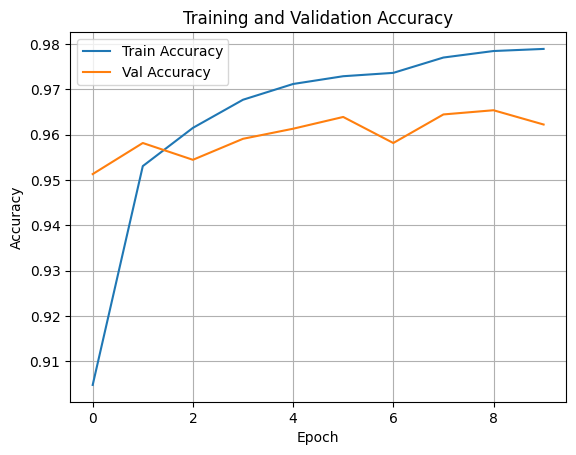

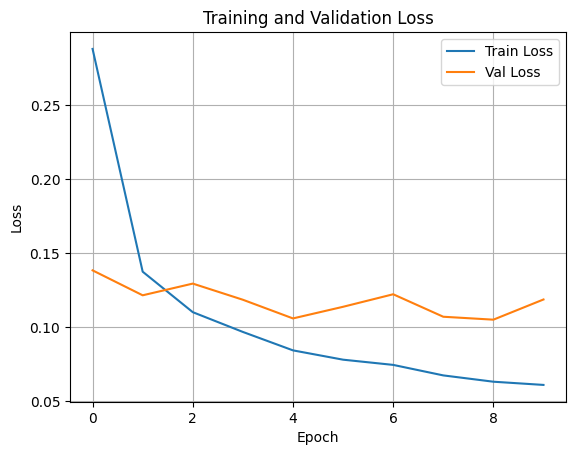

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


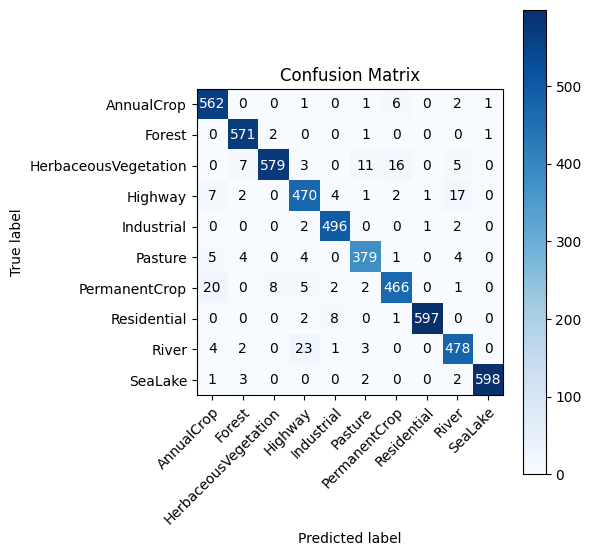

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(CLASS_NAMES)),
    yticks=np.arange(len(CLASS_NAMES)),
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix"
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


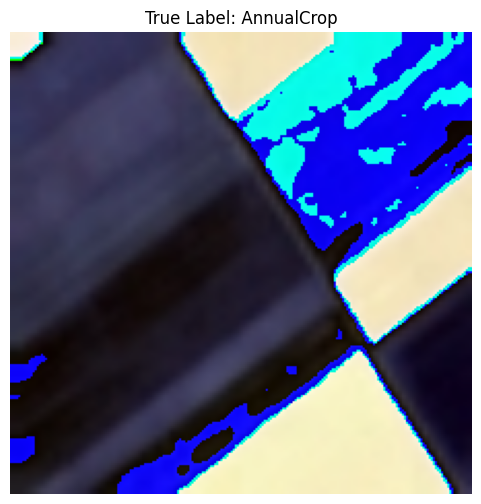

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
--- TerraScan Risk Calculation Breakdown ---
  Weather Score (0-1): 0.459
  Vegetation Score (0-1): 0.382

Predicted: AnnualCrop (Confidence: 24.87%)
Vegetation Risk Score: 0.382
TerraScan Final Risk Score: 42.84/100


In [24]:
#Grab an image from the test set
for test_images, test_labels in ds_test.take(1):
    #Get the first image that we have
    test_image = test_images[2]
    true_label = test_labels[2].numpy()
    break

#Display the image so we can test it
plt.figure(figsize=(6, 6))
plt.imshow(test_image.numpy().astype('uint8'))
plt.title(f"True Label: {CLASS_NAMES[true_label]}")
plt.axis('off')
plt.show()

#Make prediction with our model that we have
predictions = model.predict(tf.expand_dims(test_image, axis=0))
predicted_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])

#Calculate the vegetation risk
risk_class_indices = [
    CLASS_NAMES.index('AnnualCrop'),
    CLASS_NAMES.index('Pasture')
]
vegetation_risk_score = predictions[0][risk_class_indices[0]] + predictions[0][risk_class_indices[1]]

#Calculate the wildfire risk
final_score = calculate_wildfire_score(current_weather, vegetation_risk_score)

# Print results, and show if the model was correct
print(f"\nPredicted: {CLASS_NAMES[predicted_index]} (Confidence: {confidence:.2%})")
print(f"Vegetation Risk Score: {vegetation_risk_score:.3f}")
print(f"TerraScan Final Risk Score: {final_score:.2f}/100")